# Lab2:   Prediction with BigQuery ML

### Supporting Diabetes research: 

BigQuery is serverless, highly scalable, and cost-effective cloud data warehouse designed for business agility. BQ enables us to analyze petabytes of data using standard ANSI SQL at blazing-fast speeds, with zero operational overhead. BigQuery ML enables users to create and execute machine learning models within BigQuery using SQL queries. The goal is to democratize machine learning by enabling SQL practitioners to build models using their existing tools and to increase development speed by eliminating the need for data movement.

In this tutorial, you use the peptidic epitope data available as BigQuery Public-Dataset. BigQuery provides many data set for public research for Covid19 and other genomic research. The peptidic epitope dataset is sourced from NIH's IEDB and are hosted by BigQuery.
Comments & Feedback @jigmehta
## Objectives
In this tutorial, you use:
+ BigQuery `ML.CREATE` to create a classification model using the `CREATE MODEL` statement
+ The `ML.EVALUATE` function to evaluate the ML model
+ Use `ML.TRANSFORM`feature engineering functions to improve model performance
+ The `ML.PREDICT` function to make predictions using the ML model

Jupyter magics are notebook-specific shortcuts that allow you to run commands with minimal syntax. Jupyter notebooks come with many [built-in commands](https://ipython.readthedocs.io/en/stable/interactive/magics.html). The BigQuery client library, `google-cloud-bigquery`, provides a cell magic, `%%bigquery`. The `%%bigquery` magic runs a SQL query and returns the results as a pandas `DataFrame`.

## Step 1: Validate GCP Poject and Setup
Make sure you have completed Lab1 and have understood data attributes and peptide criteria we would use for our Machine Learning Model.

You can create GCP project and leverage public data set which provides free access to many datasets and free query processing. See more information [here](https://cloud.google.com/bigquery/public-data).

Lets make sure you have project setup which will be used to run queries against public dataset.

In [1]:
# Read GCP project id from env.
shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
GCP_PROJECT_ID=shell_output[0]
print("GCP project ID:" + GCP_PROJECT_ID)

GCP project ID:covid-19-271622


One can build feature table that translate Peotide Amino Acid sqquence into positioning columns. Explore amino acid properties table, it is prepared with allocation of acid sequnece number as well as additional properites that you can leverage for cross feature engineering.

In [3]:
%%bigquery --project $GCP_PROJECT_ID
SELECT *
FROM `covid-19-271622.diabetes.diabetes`

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,125,96,0,0,22.5,0.262,21,0
1,0,100,70,26,50,30.8,0.597,21,0
2,0,102,75,23,0,0.0,0.572,21,0
3,0,113,80,16,0,31.0,0.874,21,0
4,0,177,60,29,478,34.6,1.072,21,1
...,...,...,...,...,...,...,...,...,...
763,13,145,82,19,110,22.2,0.245,57,0
764,14,175,62,30,0,33.6,0.212,38,1
765,14,100,78,25,184,36.6,0.412,46,1
766,15,136,70,32,110,37.1,0.153,43,1


The amino acid table is for informational purpose here but can be leveraged further for feature engineering for epitopes and docking prediction.

## Step 2: Build First Classification Model
Building ML models with BigQuery is as simple as writing SQL statements; makes ML modeling accessible to even SQL developers and analysts. We will create a simple classification model to predict for a given peptide if there is strong binding affinity with certain HLA Allele.

Following statement creates a classification model using logistic regression. We are selecting feature columns of Allele and peptide of specific mers to classify if a peptide is a good candidate for vaccine testing.

+ Note: we are filtering data for peptides with length of 9 or 10 mers only. Also, since we run multiple samples, we are randomizing samples by 80% of data for learning.


In [4]:
%%bigquery --project $GCP_PROJECT_ID
CREATE OR REPLACE MODEL `diabetes.Classification_model`
OPTIONS
(
model_type='logistic_reg',
input_label_cols=['Outcome']
)
AS
SELECT
 Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome
 FROM
  `covid-19-271622.diabetes.diabetes`

""


The query takes several minutes to complete. After the first iteration is
complete, your model (`Classification_model_P1`) appears in the navigation panel of the
BigQuery web UI. Because the query uses a `CREATE MODEL` statement to create a
table, you do not see query results. The output is an empty `DataFrame`.

## Get training statistics

To see the results of the model training, you can use the
[`ML.TRAINING_INFO`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-train)
function, or you can view the statistics in the BigQuery web UI.
In this tutorial, you use the `ML.TRAINING_INFO` function.

A machine learning algorithm builds a model by examining many examples and
attempting to find a model that minimizes loss. This process is called empirical
risk minimization.

Loss is the penalty for a bad prediction &mdash; a number indicating
how bad the model's prediction was on a single example. If the model's
prediction is perfect, the loss is zero; otherwise, the loss is greater. The
goal of training a model is to find a set of weights that have low
loss, on average, across all examples.

To see the model training statistics that were generated when you ran the
`CREATE MODEL` query:

In [5]:
%%bigquery --project $GCP_PROJECT_ID
SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `diabetes.Classification_model`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,5,0.472245,0.490101,6.4,5036
1,0,4,0.488969,0.501924,3.2,3474
2,0,3,0.523492,0.536654,1.6,3623
3,0,2,0.573667,0.585655,0.8,8201
4,0,1,0.626688,0.634490,0.4,4256
5,0,0,0.667560,0.670812,0.2,3554


In [6]:
%%bigquery loss_curve --project $GCP_PROJECT_ID
SELECT
  iteration, loss, eval_loss
FROM
  ML.TRAINING_INFO(MODEL `diabetes.Classification_model`)
ORDER BY iteration ASC

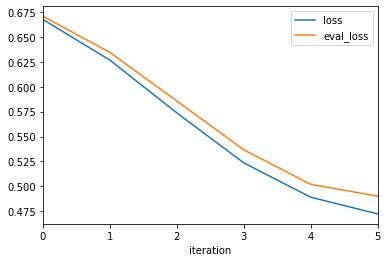

In [7]:
loss_curve.plot(x='iteration');

The `loss` column represents the loss metric calculated after the given iteration
on the training dataset. Since you performed a logistic regression, this column
is the [log loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression).
The `eval_loss` column is the same loss metric calculated on
the holdout dataset (data that is held back from training to validate the model).

For more details on the `ML.TRAINING_INFO` function, see the
[BigQuery ML syntax reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-train).

## Evaluate your model

After creating your model, you evaluate the performance of the classifier using
the [`ML.EVALUATE`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-evaluate)
function. You can also use the [`ML.ROC_CURVE`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-roc)
function for logistic regression specific metrics.

A classifier is one of a set of enumerated target values for a label. For
example, in this tutorial you are using a classification model that
detects one of the qualification class for peptide binding.

To run the `ML.EVALUATE` query that evaluates the model:

In [8]:
%%bigquery --project $GCP_PROJECT_ID
SELECT
  *
FROM ML.EVALUATE(MODEL `diabetes.Classification_model`)

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.820513,0.52459,0.767742,0.64,0.490101,0.843188


In [9]:
%%bigquery --project $GCP_PROJECT_ID
SELECT roc_auc,
       CASE WHEN roc_auc > .8 THEN 'good'
            WHEN roc_auc > .7 THEN 'fair'
            WHEN roc_auc > .5 THEN 'not great'
            ELSE 'poor' END AS model_quality
FROM ML.EVALUATE(MODEL `diabetes.Classification_model`)

,roc_auc,model_quality
0,0.843188,good


## Step 3: Improve Model Performance with Feature Engineering
BigQuery offers many [transform / preprocessing](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-preprocessing-functions) functions for feature engineering on data. Advantage of transform functions is that once you build a model with preprocessing as part of model definition, prediction data does not need to be prepared as the model will apply transformation for the input. Lets see one example of a transform feature and rebuild our model to check if we get better model performance.

Following statement will create another classification model with preprocessing of the Quantitative_measurement to normalize its deviation with respect to min-max value of an attribute. Another example of feature engineering is commented with cross freature generation example.


In [15]:
%%bigquery --project $GCP_PROJECT_ID
CREATE OR REPLACE MODEL `diabetes.Classification_model2`
TRANSFORM (Pregnancies, Glucose, BloodPressure, SkinThickness, BMI, DiabetesPedigreeFunction, Age, Outcome,
#           ML.FEATURE_CROSS(STRUCT(Description,Allele_Name)) AS mhc_peptide,
           ML.MIN_MAX_SCALER(Insulin) OVER() AS rs
)
OPTIONS
(
model_type='logistic_reg',
input_label_cols=['Outcome']
)
AS
SELECT
 Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome
 FROM
  `covid-19-271622.diabetes.diabetes`

""


The query takes several minutes to complete. After the first iteration is
complete, your model (`Classification_model_P2`) appears in the navigation panel of the
BigQuery web UI. The output is an empty `DataFrame`.

Check model performance after feature engineering, run the `ML.EVALUATE` query that evaluates the model:

In [16]:
%%bigquery loss_curve2 --project $GCP_PROJECT_ID
SELECT
  iteration, loss, eval_loss
FROM
  ML.TRAINING_INFO(MODEL `diabetes.Classification_model2`)
ORDER BY iteration ASC

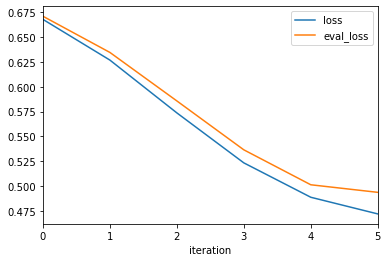

In [17]:
loss_curve2.plot(x='iteration');

In [18]:
%%bigquery --project $GCP_PROJECT_ID
SELECT roc_auc,
       CASE WHEN roc_auc > .8 THEN 'good'
            WHEN roc_auc > .7 THEN 'fair'
            WHEN roc_auc > .5 THEN 'not great'
            ELSE 'poor' END AS model_quality
FROM ML.EVALUATE(MODEL `diabetes.Classification_model2`)

,roc_auc,model_quality
0,0.843188,good


As you can see model performance has improved!

With BigQuery you can take advantage of an already available highly powerful computer data processing and analysis platform to build a machine learning model, without moving your data! You can learn more about BQML here. For our data set, you can build a DNN_Regression model to predict the result_score for a peptide HLA binding. Try that as a practice!

## Step 4: Run Prediction on BQML Model
Now that you have evaluated your model, the next step is to use it to predict
outcomes. 

To run the query that uses the model to predict the number of transactions:
Following example demonstrate leveraging BQ model for prediction. Optionally, you can export model and publish it on to Google AI Platform for serving prediction.


In [20]:
%%bigquery --project $GCP_PROJECT_ID
SELECT
  *
FROM ML.PREDICT(MODEL `diabetes.Classification_model2`, (
 SELECT
 Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome
 FROM
  `covid-19-271622.diabetes.diabetes`))

,predicted_Outcome,predicted_Outcome_probs,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,"[{'label': 1, 'prob': 0.08007324972320054}, {'...",0,125,96,0,0,22.5,0.262,21,0
1,0,"[{'label': 1, 'prob': 0.12304763125293537}, {'...",0,100,70,26,50,30.8,0.597,21,0
2,0,"[{'label': 1, 'prob': 0.011837027981999771}, {...",0,102,75,23,0,0.0,0.572,21,0
3,0,"[{'label': 1, 'prob': 0.1973796735979391}, {'l...",0,113,80,16,0,31.0,0.874,21,0
4,1,"[{'label': 1, 'prob': 0.6430073998820943}, {'l...",0,177,60,29,478,34.6,1.072,21,1
...,...,...,...,...,...,...,...,...,...,...,...
763,0,"[{'label': 1, 'prob': 0.48909225366148185}, {'...",13,145,82,19,110,22.2,0.245,57,0
764,1,"[{'label': 1, 'prob': 0.8425977573691732}, {'l...",14,175,62,30,0,33.6,0.212,38,1
765,0,"[{'label': 1, 'prob': 0.4850925059036358}, {'l...",14,100,78,25,184,36.6,0.412,46,1
766,1,"[{'label': 1, 'prob': 0.7103099750816511}, {'l...",15,136,70,32,110,37.1,0.153,43,1


The result shows predicted quality class with confidence. You can compare that with original result. Next step is to operationalize ML pipeline so that you can efficiently perform data updates and model updates. Check out AI Pipeline example for peptide prediction to learn more!

### This is end of Lab2! Congratualtions!